In [120]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import glob
import os

## betaJ 0010

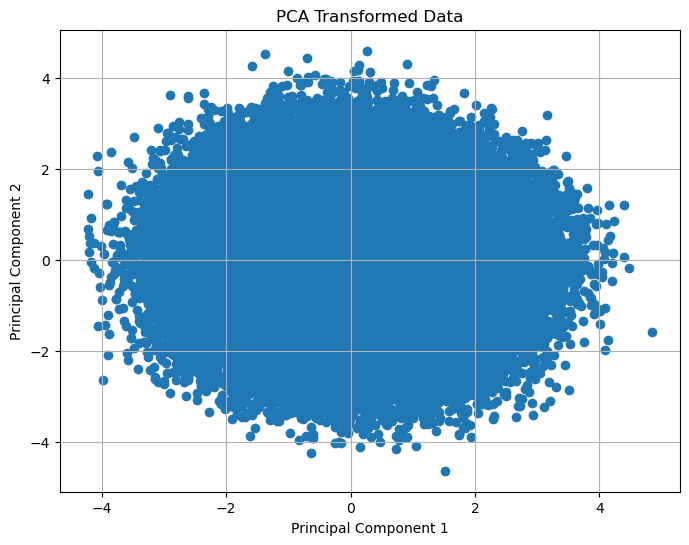

In [121]:
directory_path = '/home/user/IsingData/Data/betaJ-0010_vf-050_nrows-100_ncols-100'
full_paths = glob.glob(os.path.join(directory_path, 'spins_iter-*.csv'))

flist = []
for filename in full_paths:
    df = pd.read_csv(filename, index_col=False) 
    flist.append(df)

df_out = pd.concat(flist, axis=0, ignore_index=False)
df_out.to_csv("output_0010.csv")

df = pd.read_csv('/home/user/IsingData/output_0010.csv')
df = df.dropna(axis=1)
scaler = sklearn.preprocessing.StandardScaler()
scaled = scaler.fit_transform(df)

pca = sklearn.decomposition.PCA(n_components=4)
pca.fit(scaled)

principal_components = pca.transform(scaled)

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Transformed Data')
plt.grid(True)
plt.show()



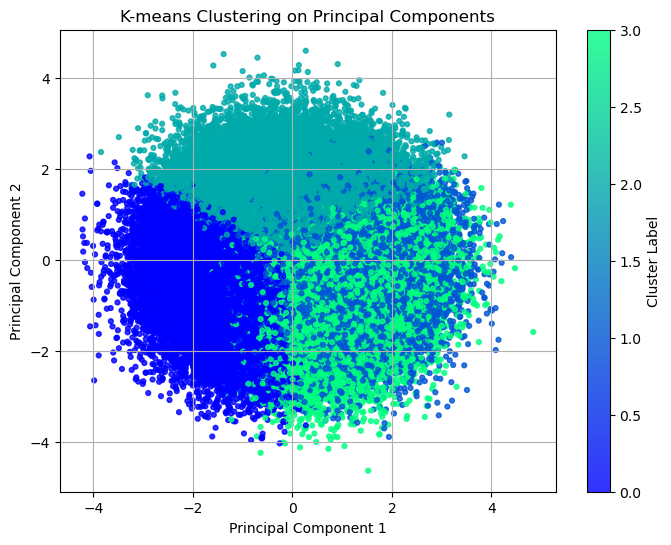

In [122]:
dfkmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(principal_components)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, s=12, alpha=0.8, cmap='winter')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on Principal Components')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()


## betaJ 0100

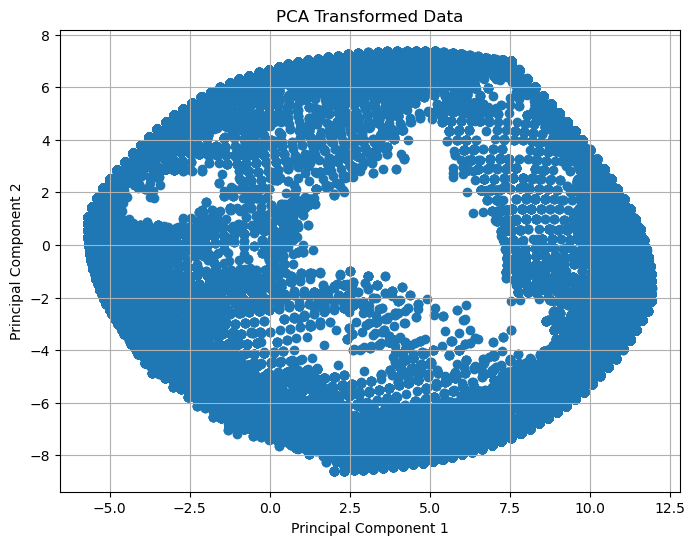

In [123]:
directory_path = '/home/user/IsingData/Data/betaJ-0100_vf-050_nrows-100_ncols-100'
full_paths = glob.glob(os.path.join(directory_path, 'spins_iter-*.csv'))

flist = []
for filename in full_paths:
    df = pd.read_csv(filename, index_col=False) 
    flist.append(df)

df_out = pd.concat(flist, axis=0, ignore_index=False)
df_out.to_csv("output_0100.csv")

df = pd.read_csv('/home/user/IsingData/output_0100.csv')
df = df.dropna(axis=1)
scaler = sklearn.preprocessing.StandardScaler()
scaled = scaler.fit_transform(df)

pca = sklearn.decomposition.PCA(n_components=4)
pca.fit(scaled)

principal_components = pca.transform(scaled)

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Transformed Data')
plt.grid(True)
plt.show()

plt.show()

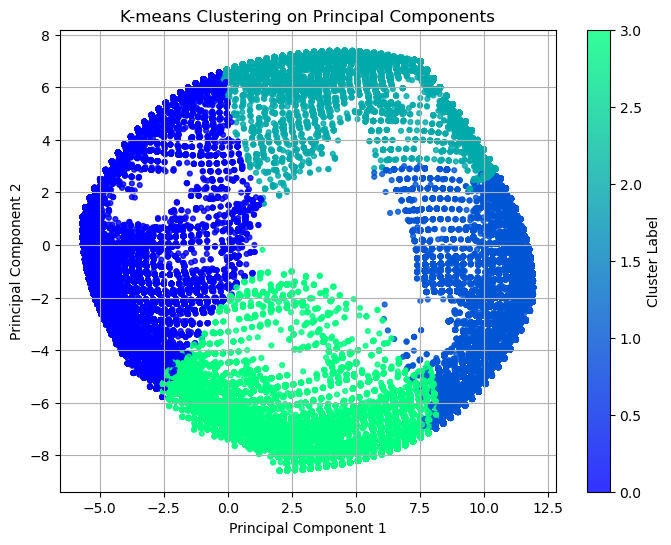

In [124]:
dfkmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(principal_components)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, s=12, alpha=0.8, cmap='winter')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on Principal Components')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

## betaJ 1000

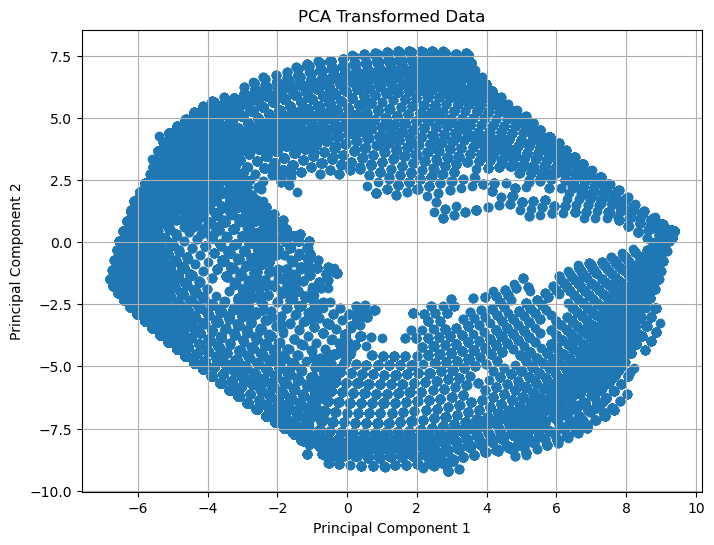

In [125]:
directory_path = '/home/user/IsingData/Data/betaJ-1000_vf-050_nrows-100_ncols-100'
full_paths = glob.glob(os.path.join(directory_path, 'spins_iter-*.csv'))

flist = []
for filename in full_paths:
    df = pd.read_csv(filename, index_col=False) 
    flist.append(df)

df_out = pd.concat(flist, axis=0, ignore_index=False)
df_out.to_csv("output_1000.csv")

df = pd.read_csv('/home/user/IsingData/output_1000.csv')
df = df.dropna(axis=1)
scaler = sklearn.preprocessing.StandardScaler()
scaled = scaler.fit_transform(df)

pca = sklearn.decomposition.PCA(n_components=4)
pca.fit(scaled)

principal_components = pca.transform(scaled)

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Transformed Data')
plt.grid(True)
plt.show()

plt.show()

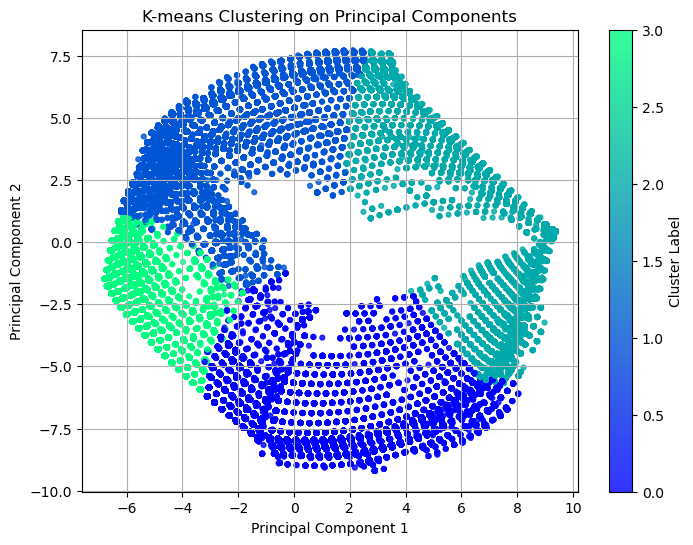

In [126]:
dfkmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(principal_components)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, s=12, alpha=0.8, cmap='winter')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on Principal Components')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

## betaJ 0200 w 025vf

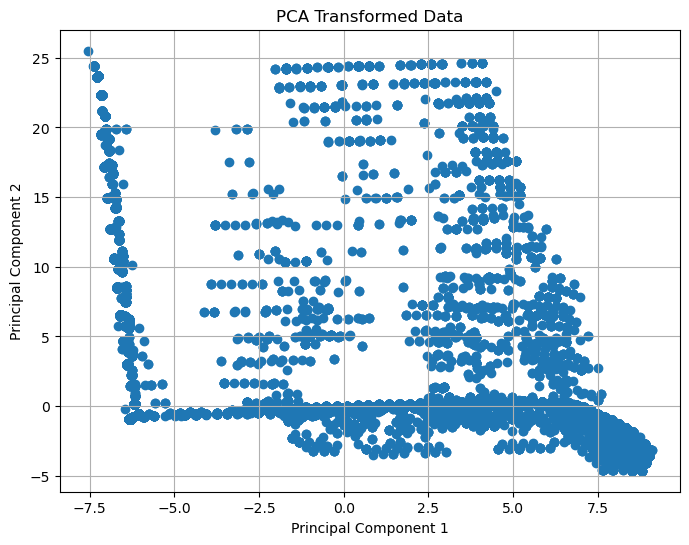

In [127]:
directory_path = '/home/user/IsingData/Data/betaJ-0200_vf-025_nrows-100_ncols-100'
full_paths = glob.glob(os.path.join(directory_path, 'spins_iter-*.csv'))

flist = []
for filename in full_paths:
    df = pd.read_csv(filename, index_col=False) 
    flist.append(df)

df_out = pd.concat(flist, axis=0, ignore_index=False)
df_out.to_csv("output_0200_025.csv")

df = pd.read_csv('/home/user/IsingData/output_0200_025.csv')
df = df.dropna(axis=1)
scaler = sklearn.preprocessing.StandardScaler()
scaled = scaler.fit_transform(df)

pca = sklearn.decomposition.PCA(n_components=4)
pca.fit(scaled)

principal_components = pca.transform(scaled)

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Transformed Data')
plt.grid(True)
plt.show()

plt.show()

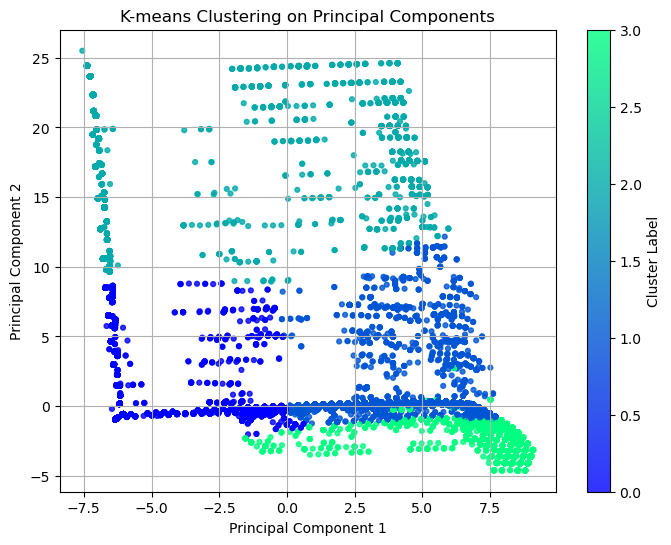

In [128]:
dfkmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(principal_components)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, s=12, alpha=0.8, cmap='winter')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on Principal Components')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

## betaJ 0200 vf 050

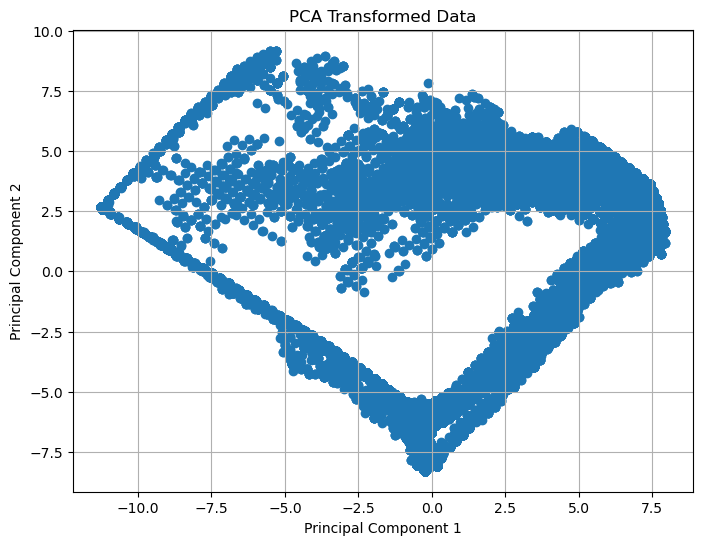

In [129]:
directory_path = '/home/user/IsingData/Data/betaJ-0200_vf-050_nrows-100_ncols-100'
full_paths = glob.glob(os.path.join(directory_path, 'spins_iter-*.csv'))

flist = []
for filename in full_paths:
    df = pd.read_csv(filename, index_col=False) 
    flist.append(df)

df_out = pd.concat(flist, axis=0, ignore_index=False)
df_out.to_csv("output_0200_050.csv")

df = pd.read_csv('/home/user/IsingData/output_0200_050.csv')
df = df.dropna(axis=1)
scaler = sklearn.preprocessing.StandardScaler()
scaled = scaler.fit_transform(df)

pca = sklearn.decomposition.PCA(n_components=4)
pca.fit(scaled)

principal_components = pca.transform(scaled)

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Transformed Data')
plt.grid(True)
plt.show()

plt.show()

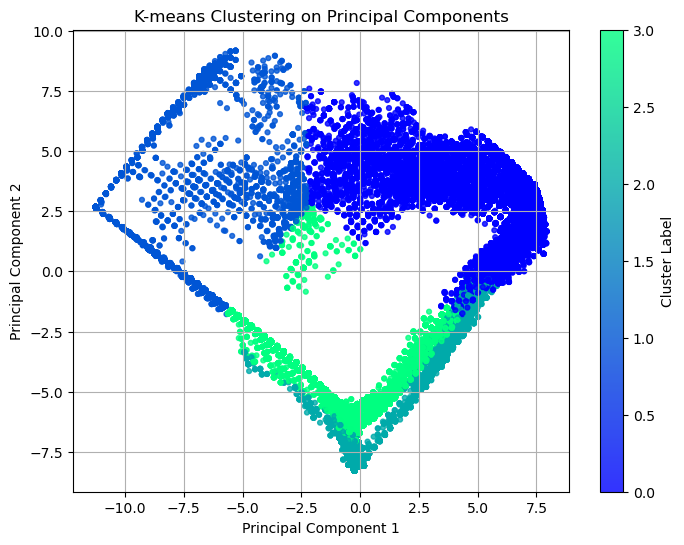

In [130]:
dfkmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(principal_components)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, s=12, alpha=0.8, cmap='winter')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on Principal Components')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

## betaJ 0200 vf 075

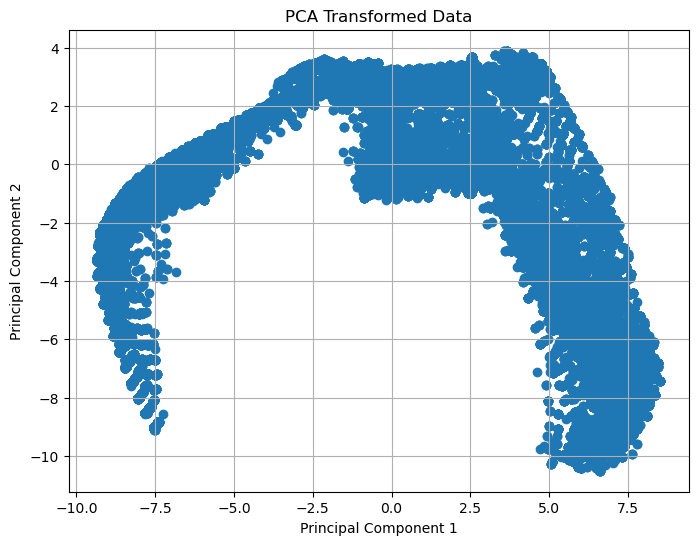

In [131]:
directory_path = '/home/user/IsingData/Data/betaJ-0200_vf-075_nrows-100_ncols-100'
full_paths = glob.glob(os.path.join(directory_path, 'spins_iter-*.csv'))

flist = []
for filename in full_paths:
    df = pd.read_csv(filename, index_col=False) 
    flist.append(df)

df_out = pd.concat(flist, axis=0, ignore_index=False)
df_out.to_csv("output_0200_075.csv")

df = pd.read_csv('/home/user/IsingData/output_0200_075.csv')
df = df.dropna(axis=1)
scaler = sklearn.preprocessing.StandardScaler()
scaled = scaler.fit_transform(df)

pca = sklearn.decomposition.PCA(n_components=4)
pca.fit(scaled)

principal_components = pca.transform(scaled)

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Transformed Data')
plt.grid(True)
plt.show()

plt.show()

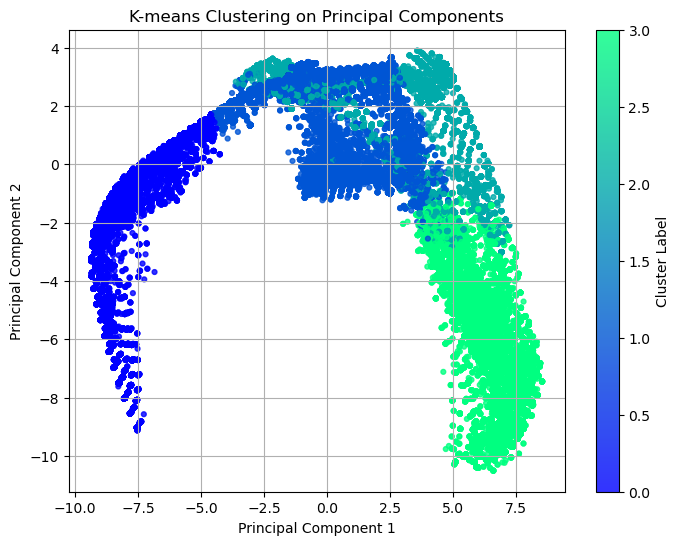

In [132]:
dfkmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(principal_components)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, s=12, alpha=0.8, cmap='winter')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on Principal Components')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

## betaJ 0200 vf 080

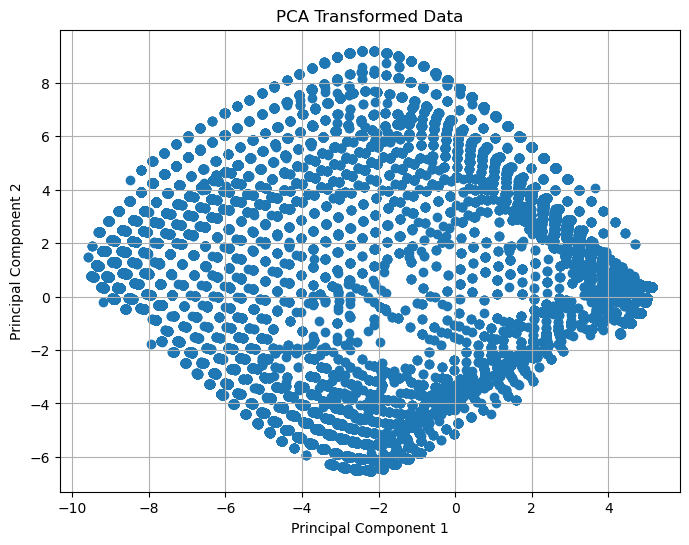

In [133]:
directory_path = '/home/user/IsingData/Data/betaJ-0200_vf-080_nrows-100_ncols-100'
full_paths = glob.glob(os.path.join(directory_path, 'spins_iter-*.csv'))

flist = []
for filename in full_paths:
    df = pd.read_csv(filename, index_col=False) 
    flist.append(df)

df_out = pd.concat(flist, axis=0, ignore_index=False)
df_out.to_csv("output_0200_080.csv")

df = pd.read_csv('/home/user/IsingData/output_0200_080.csv')
df = df.dropna(axis=1)
scaler = sklearn.preprocessing.StandardScaler()
scaled = scaler.fit_transform(df)

pca = sklearn.decomposition.PCA(n_components=4)
pca.fit(scaled)

principal_components = pca.transform(scaled)

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Transformed Data')
plt.grid(True)
plt.show()

plt.show()

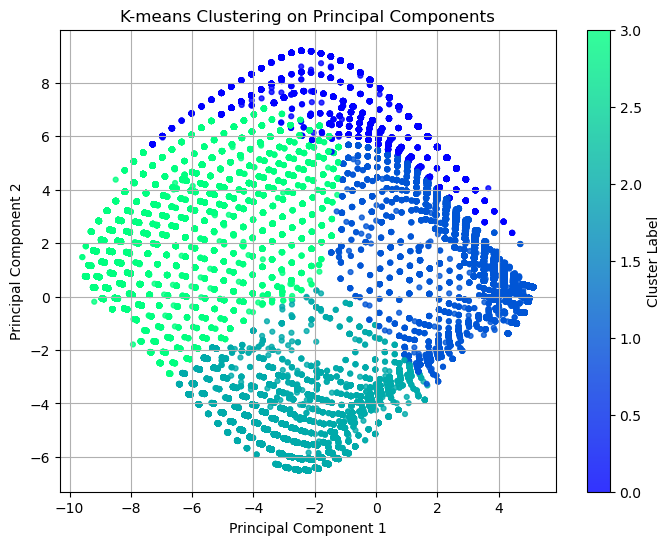

In [134]:
dfkmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(principal_components)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, s=12, alpha=0.8, cmap='winter')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on Principal Components')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()